In [1]:
!pip install qiskit

     |████████████████████████████████| 6.1 MB 5.1 MB/s 
     |████████████████████████████████| 18.0 MB 130 kB/s 
     |████████████████████████████████| 235 kB 71.3 MB/s 
     |████████████████████████████████| 207 kB 59.1 MB/s 
     |████████████████████████████████| 2.1 MB 42.3 MB/s 
     |████████████████████████████████| 200 kB 61.7 MB/s 
     |████████████████████████████████| 635 kB 61.0 MB/s 
     |████████████████████████████████| 1.4 MB 56.1 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 33.9 MB 16 kB/s 
     |████████████████████████████████| 943 kB 54.1 MB/s 
     |████████████████████████████████| 3.2 MB 44.7 MB/s 
     |████████████████████████████████| 6.3 MB 44.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.29.0-py3-none-any.whl size=11179 sha256=d245546039159a62e8357abb6dc634f0da0d2b6445f0528bea29404a45af7fee
  Stored in directory: /root/.cache/pip/whe

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.utils import resample
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
from time import time
from sklearn.model_selection import train_test_split
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>


# Loading data

In [3]:
df = 'parkinsons.csv'
df1 = pd.read_csv(df)
df2=df1.drop(['name'],axis=1)

In [4]:
df2.shape

(195, 23)

Preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


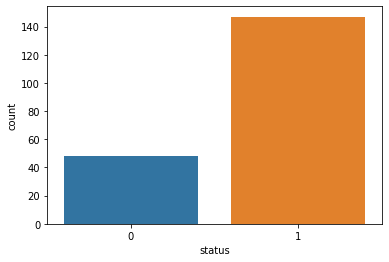

In [5]:
sns.countplot(df2['status'],label="Count")

In [6]:
# balance data
# Separate majority and minority classes
data_majority = df2[df2.status==1]
data_minority = df2[df2.status==0] 
# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True, 
                                 n_samples=data_majority.shape[0], 
                                 random_state=123)
# Combine majority class with upsampled minority class
df3 = pd.concat([data_minority_upsampled, data_majority])
 # Display new class counts
df3.status.value_counts()

1    147
0    147
Name: status, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


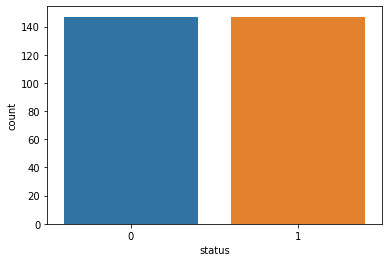

In [7]:
sns.countplot(df3['status'],label="Count")

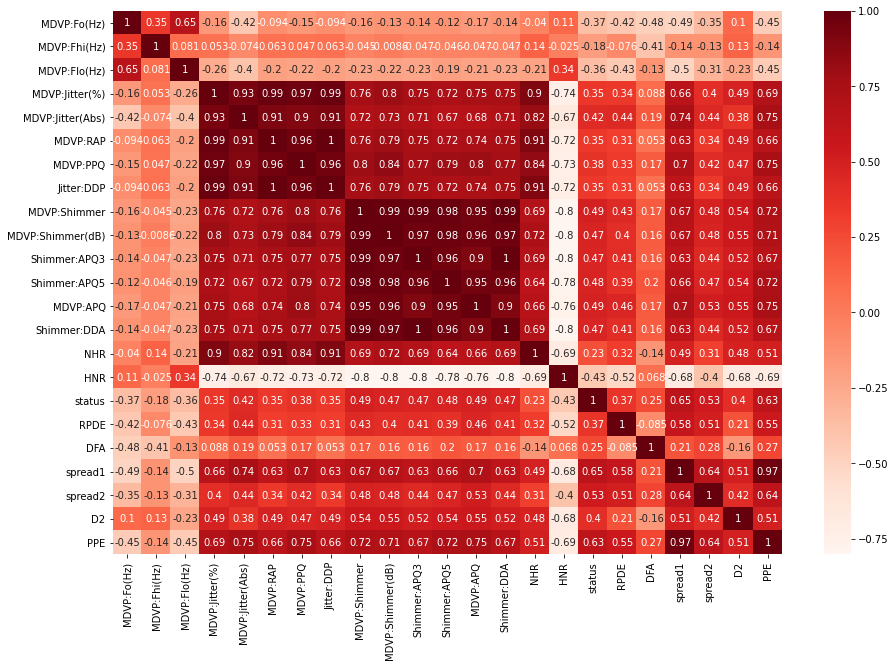

In [8]:
#Using Pearson Correlation
plt.figure(figsize=(15,10))
cor = df3.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [12]:
# Pairwise relationships between continuous variables
corr_metrics = df3.corr()
#corr_metrics.style.background_gradient()

In [13]:
#we have the correlation matrix in order descent following the status
#corr_metrics = df3[sorted_index].corr()
corr_metrics.style.background_gradient()

In [14]:
# drop one of the pairs highly correlated features
#Esorina izay correlated features ka izay kely correlation amin ny status no miala (ampidirina anaty list ny anarany)
correlated_features1=set()
for i in range(len(corr_metrics.columns)):
    for j in range(i):
        if abs(corr_metrics.iloc[i, j]) >= 0.95:
            colname = corr_metrics.columns[i]
            correlated_features1.add(colname)

In [15]:
correlated_features1

{'Jitter:DDP',
 'MDVP:APQ',
 'MDVP:PPQ',
 'MDVP:RAP',
 'MDVP:Shimmer(dB)',
 'PPE',
 'Shimmer:APQ3',
 'Shimmer:APQ5',
 'Shimmer:DDA'}

In [16]:
# create the new dataset by drawing the correlated features features
df4=df3.drop(['Jitter:DDP',
 'MDVP:APQ',
 'MDVP:PPQ',
 'MDVP:RAP',
 'MDVP:Shimmer(dB)',
 'PPE',
 'Shimmer:APQ3',
 'Shimmer:APQ5',
 'Shimmer:DDA'], axis=1)

In [17]:
data=df4

In [18]:
data.shape

(294, 14)

In [19]:
data

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  ...   spread1   spread2        D2
192      174.688       240.005        74.287  ... -6.787197  0.158453  2.679772
32       198.383       215.203       193.104  ... -7.067931  0.175181  1.512275
169      240.301       245.135       219.783  ... -7.169701  0.073298  2.266432
175      115.380       123.109       108.634  ... -5.966779  0.197938  1.974857
185      116.286       177.291        96.983  ... -5.592584  0.133917  2.058658
..           ...           ...           ...  ...       ...       ...       ...
178      148.790       158.359       138.990  ... -6.311987  0.182459  2.251553
179      148.143       155.982       135.041  ... -5.711205  0.240875  2.845109
180      150.440       163.441       144.736  ... -6.261446  0.183218  2.264226
181      148.462       161.078       141.998  ... -5.704053  0.216204  2.679185
182      149.818       163.417       144.786  ... -6.277170  0.109397  2.209021

[294 rows x 14 columns]

# Quantum support vector machine

In [20]:
#store the categories of healthy people
heal=data[data['status']==0]
heal1=heal.drop('status',axis=1)
# store the parkinson
park=data[data['status']==1]
park1=park.drop('status',axis=1)

In [21]:
#Divide dataset into training and testing with a 7:3 ratio
p_train, p_test, h_train, h_test = train_test_split(park1,heal1, test_size=0.3,random_state=19)

In [22]:
# to scale the data to be between -1 and 1
samples = np.append(h_train, h_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
h_train = minmax_scale.transform(h_train)
h_test = minmax_scale.transform(h_test)

In [23]:
# to scale the data to be between -1 and 1
samples1 = np.append(p_train, p_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples1)
p_train = minmax_scale.transform(p_train)
p_test = minmax_scale.transform(p_test)

In [24]:
#Combine training/testing arrays
training_data={'A': h_train, 'B': p_train}
testing_data = {'A' : h_test, 'B': p_test}

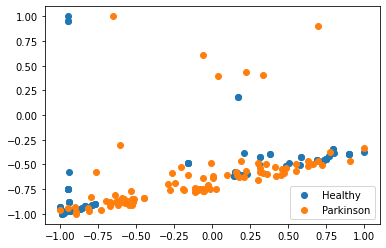

In [25]:
# Plot the training dataset
plt.scatter(training_data['A'][:,0], training_data['A'][:,1],label='Healthy')
plt.scatter(training_data['B'][:,0], training_data['B'][:,1],label='Parkinson')
plt.legend( loc='lower right')
plt.show()

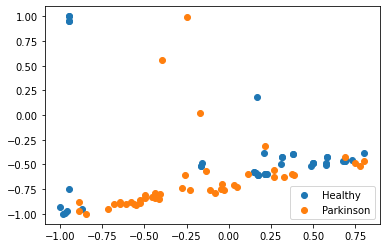

In [26]:
# Plot testing data
plt.scatter(testing_data['A'][:,0], testing_data['A'][:,1],label='Healthy')
plt.scatter(testing_data['B'][:,0], testing_data['B'][:,1],label='Parkinson')
plt.legend( loc='lower right')
plt.show()

In [27]:
t0= time()

In [28]:
# Load accounts
from qiskit import IBMQ
IBMQ.load_account()
provider=IBMQ.get_provider()

In [30]:
feature_dim = 13
shot = 1024
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map,training_data,testing_data)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=shot, seed_simulator=seed, seed_transpiler=seed)

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/classifiers/qsvm/qsvm.py:104: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit-machine-learning')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit-terra')


In [31]:
#Run the QSVM for accuracy results
result = qsvm.run(quantum_instance)
tpy = time() - t0
print ("Duration in Seconds: %7.3f" % tpy)

Duration in Seconds: 3749.664


/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/classifiers/qsvm/_qsvm_binary.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  predicted_labels = binarized_predictions.astype(int)


In [32]:
print("Quantum accuracy on test set: {0}%".format(round(result['testing_accuracy']*100, 2)))

Quantum accuracy on test set: 95.56%


In [33]:
# Apply prediction on testing data
test_set = np.concatenate((testing_data['A'], testing_data['B']))
y_test = qsvm.predict(test_set, quantum_instance)
tpy1 = time() - t0
print ("Duration total of simulation (training + testing) in Seconds: %7.3f" % tpy1)

Duration total of simulation (training + testing) in Seconds: 5768.634


/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/classifiers/qsvm/_qsvm_binary.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  predicted_labels = binarized_predictions.astype(int)


### Plot shows the ground truth of test labels.

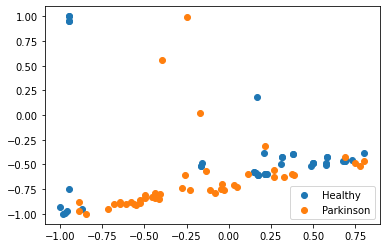

In [34]:
plt.scatter(testing_data['A'][:,0], testing_data['A'][:,1],label='Healthy')
plt.scatter(testing_data['B'][:,0], testing_data['B'][:,1], label='Parkinson')
plt.legend( loc='lower right')
plt.show()

### Plotting the label predictions of the QSVM

In [35]:
dic={"A":test_set[y_test==0],"B":test_set[y_test==1]}

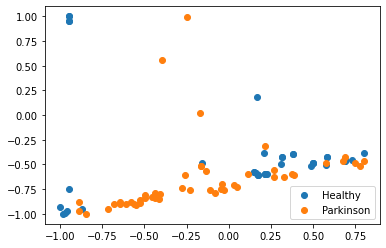

In [36]:
plt.scatter(dic['A'][:,0], dic['A'][:,1],label="Healthy")
plt.scatter(dic['B'][:,0], dic['B'][:,1],label="Parkinson")
plt.legend( loc='lower right')
plt.show()

In [37]:
from qiskit.aqua.algorithms import SklearnSVM
svm_classical = SklearnSVM(training_data,testing_data)
result_classical = svm_classical.run()
tpy2 = time() - t0
print ("Duration in Seconds: %7.3f" % tpy2)

Duration in Seconds: 5790.282


In [38]:
print('testing success ratio: ', (result_classical['testing_accuracy'])*100)

testing success ratio:  97.77777777777777


In [39]:
x_test = np.concatenate((testing_data['A'], testing_data['B']))
y_pred = svm_classical.predict(x_test)

In [40]:
dic1={'A':x_test[y_pred==0],'B':x_test[y_pred==1]}

### Plot label prediction with SVM

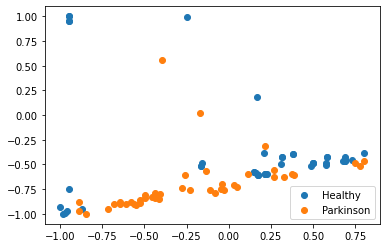

In [41]:
plt.scatter(dic1['A'][:,0], dic1['A'][:,1],label="Healthy")
plt.scatter(dic1['B'][:,0], dic1['B'][:,1],label="Parkinson")
plt.legend( loc='lower right')
plt.show()